# Exploratory Data Analysis

This notebook contains some EDA on the BIODIV dataset and creates a filtered version of this dataset as well

# Helper functions

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

def plot_df_histograms(df, sample_size=None):
    # If sample_size is provided, sample the data
    if sample_size is not None:
        df = df.sample(n=sample_size, random_state=42)

    # Calculate the number of features
    features = df.columns
    n_features = len(features)
    n_cols = 4
    n_rows = (n_features + n_cols - 1) // n_cols

    # Create a figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, n_rows * 6))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    for i, feature in enumerate(features):
        sns.histplot(df[feature], kde=False, ax=axes[i])

        # Get the x-axis tick labels and their positions
        x_labels = axes[i].get_xticks()
        x_labels_text = [label.get_text() for label in axes[i].get_xticklabels()]

        # Truncate the x-axis labels if they are longer than 7 characters
        truncated_labels = [text[:7] + '...' if len(text) > 7 else text for text in x_labels_text]

        # Set the new tick labels using FixedFormatter and FixedLocator
        axes[i].xaxis.set_major_locator(ticker.FixedLocator(x_labels))
        axes[i].xaxis.set_major_formatter(ticker.FixedFormatter(truncated_labels))

        # Rotate the labels for better readability
        axes[i].set_xticklabels(truncated_labels, rotation=45, ha='right')

        axes[i].set_title(f'{feature}')

    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust the layout manually
    plt.subplots_adjust(wspace=0.4, hspace=0.6)
    plt.show()

# Mounting drive and importing files

In [3]:
import os
from google.colab import drive
drive.mount('/content/drive')

# Define the path to the folder
seamap_path = '/content/drive/MyDrive/ColabNotebooks/seamap_survey'

# Check if the path exists, and adjust if it doesn't
if not os.path.exists(seamap_path):
    seamap_path = '/content/drive/MyDrive/seamap_survey/'  # Ensure this path is correct

# Use the variable to change directory
%cd $seamap_path

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1QT3TfXsCu6j2HwKUeQ8-kOZitEMg55iO/seamap_survey


In [4]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot  as plt

#Loading the data
df_raw = pd.read_csv('dataframes/BIODIV_FULL_dataset.csv')

#Looking at the features
df_raw.columns

Index(['PRECIP', 'DEPTH_ESRF', 'DEPTH_EMID', 'DEPTH_EMAX', 'DEPTH_EWTR',
       'DEPTH_SSTA', 'DEPTH_ESTA', 'TEMPSURF', 'TEMPMID', 'TEMPMAX',
       'TEMP_SSURF', 'TEMP_BOT', 'TEMP_SAIR', 'SALSURF', 'SALMID', 'SALMAX',
       'CHLORSURF', 'CHLORMID', 'CHLORMAX', 'OXYSURF', 'OXYMID', 'OXYMAX',
       'TURBSURF', 'TURBMID', 'TURBMAX', 'WIND_SPD', 'WIND_DIR', 'START_DATE',
       'END_DATE', 'CNT', 'CNTEXP', 'BIO_BGS', 'DECSLAT', 'DECSLON', 'DECELAT',
       'DECELON', 'SAMPLE_BGS', 'DATE', 'WEEK'],
      dtype='object')

In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 722333 entries, 0 to 722332
Data columns (total 39 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   PRECIP      572187 non-null  float64
 1   DEPTH_ESRF  683020 non-null  float64
 2   DEPTH_EMID  699880 non-null  float64
 3   DEPTH_EMAX  707936 non-null  float64
 4   DEPTH_EWTR  721329 non-null  float64
 5   DEPTH_SSTA  722232 non-null  float64
 6   DEPTH_ESTA  691886 non-null  float64
 7   TEMPSURF    706225 non-null  float64
 8   TEMPMID     695010 non-null  float64
 9   TEMPMAX     703327 non-null  float64
 10  TEMP_SSURF  704346 non-null  float64
 11  TEMP_BOT    697637 non-null  float64
 12  TEMP_SAIR   699357 non-null  float64
 13  SALSURF     698102 non-null  float64
 14  SALMID      690440 non-null  float64
 15  SALMAX      698880 non-null  float64
 16  CHLORSURF   566327 non-null  float64
 17  CHLORMID    434029 non-null  float64
 18  CHLORMAX    459275 non-null  float64
 19  OX

# Filter by cuttoff info from previous notebooks

In [6]:
#Here are a bunch of steps filtering the dataframe
df_filtered = df_raw.copy()
df_filtered.drop(df_filtered[df_filtered['TEMPSURF'] < 5].index, inplace=True) # Getting rid of unreasonably cold or hot measurements.
df_filtered.drop(df_filtered[df_filtered['TEMPMID'] < 5].index, inplace=True)
df_filtered.drop(df_filtered[df_filtered['TEMPMID'] > 35].index, inplace=True)
df_filtered.drop(df_filtered[df_filtered['OXYMAX'] > 20].index, inplace=True) # Getting rid of unreasonably high oxygen readings. The cutoff of 20 is from the documentation page 13
df_filtered.drop(df_filtered[df_filtered['OXYMID'] > 20].index, inplace=True)
df_filtered.drop(df_filtered[df_filtered['OXYSURF'] > 20].index, inplace=True)
df_filtered.drop(df_filtered[df_filtered['CHLORSURF'] < 0].index, inplace=True) # Cholorophyll won't be negative
df_filtered.drop(df_filtered[df_filtered['CHLORMID'] < 0].index, inplace=True)
df_filtered.drop(df_filtered[df_filtered['CHLORMAX'] < 0].index, inplace=True)
df_filtered.drop(df_filtered[df_filtered['TURBMAX'] > 100].index, inplace=True)
df_filtered.drop(df_filtered[df_filtered['TEMP_BOT'] < 5].index, inplace=True)
df_filtered.drop(df_filtered[df_filtered['TEMP_BOT'] > 35].index, inplace=True) #I don't think the bottom of the ocean will be 35 C
df_filtered.drop(df_filtered[df_filtered['TEMP_SSURF'] < -1.1].index, inplace=True) #It seems strange that the readings can be less than 0, but the documentation gives this as the lower bound of the range
df_filtered.drop(df_filtered[df_filtered['TEMP_SAIR'] > 50].index, inplace=True) # For some reason, occasionally there are air temp readings of 100 or 212 C

# Checking S(tart) and E(nd) values to simplify time/location choice
Because start and end may be far apart we want to see the variance in start and end to see if we should omit or reat certain information more carefully.

In [7]:
# Convert START_DATE and END_DATE to datetime
df_filtered['START_DATE'] = pd.to_datetime(df_filtered['START_DATE'])
df_filtered['END_DATE'] = pd.to_datetime(df_filtered['END_DATE'])

# Extract date and week information
df_filtered['DATE'] = df_filtered['START_DATE'].dt.date
df_filtered['WEEK'] = df_filtered['START_DATE'].dt.to_period('W').apply(lambda r: r.start_time)

In [8]:
# Calculate differences for plotting
df_filtered['DATE_DIFF'] = (df_filtered['END_DATE'] - df_filtered['START_DATE']).dt.total_seconds() / 3600  # Difference in hours
df_filtered['LAT_DIFF'] = df_filtered['DECELAT'] - df_filtered['DECSLAT']
df_filtered['LON_DIFF'] = df_filtered['DECELON'] - df_filtered['DECSLON']

initial_rows = df_filtered['DATE_DIFF'].count()

# Remove entries with large time and long/lat difference between start/end of trip
df_filtered.drop(df_filtered[df_filtered['DATE_DIFF'] > 10].index, inplace=True)
df_filtered.drop(df_filtered[df_filtered['LAT_DIFF'].abs() > 0.25].index, inplace=True)
df_filtered.drop(df_filtered[df_filtered['LON_DIFF'].abs() > 0.25].index, inplace=True)

total_dropped = initial_rows - df_filtered['DATE_DIFF'].count()
print(f"Total rows dropped: {total_dropped}")

Total rows dropped: 178


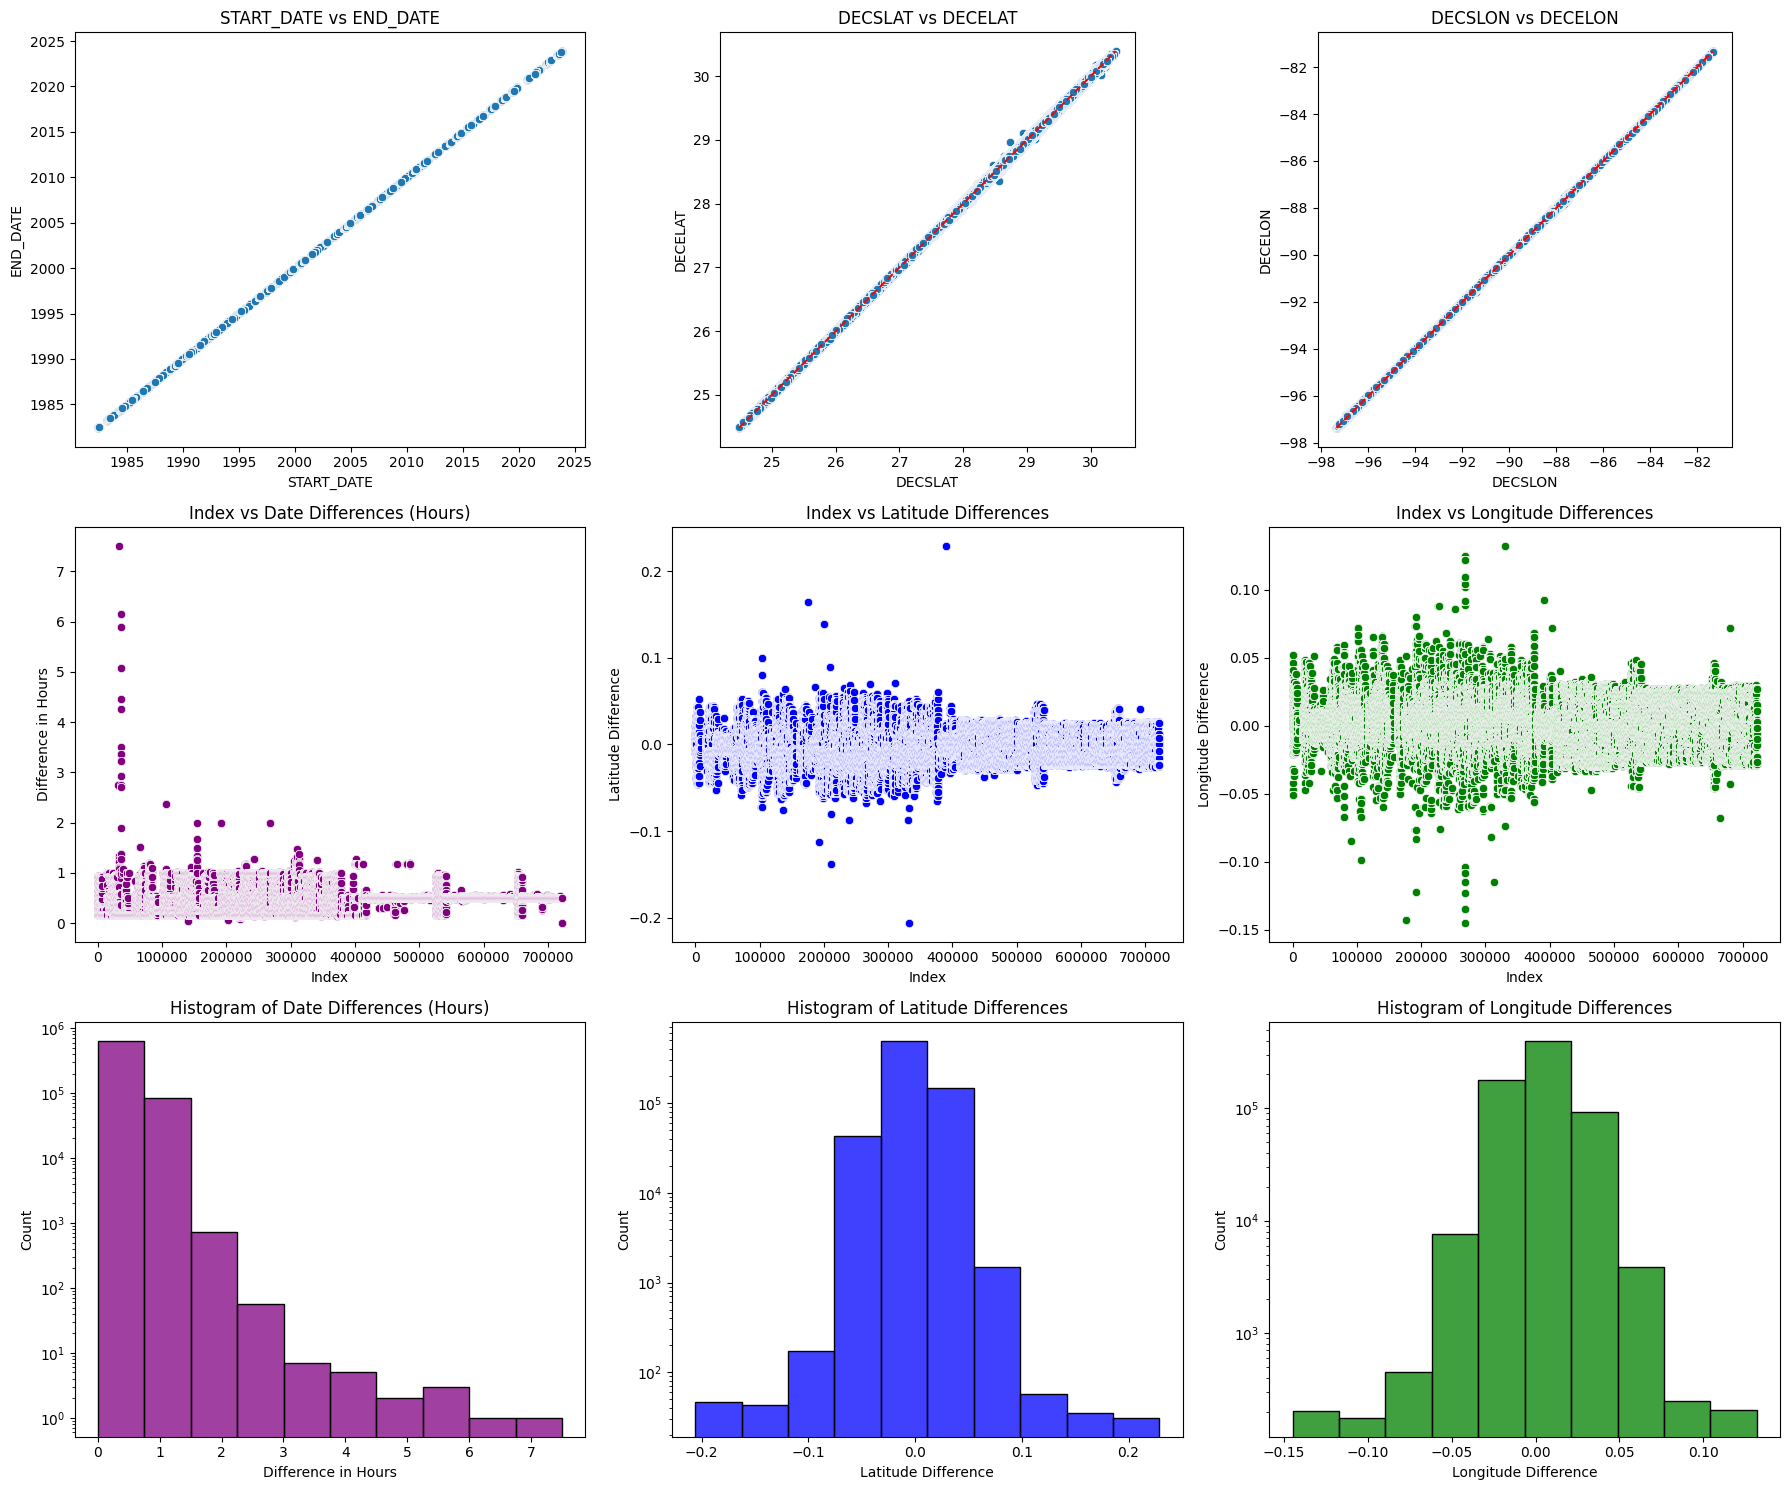

In [9]:

# Set up the subplots with 3 rows and 3 columns
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 15))

# Plot START_DATE vs END_DATE
sns.scatterplot(x=df_filtered['START_DATE'], y=df_filtered['END_DATE'], ax=axes[0, 0])
axes[0, 0].set_title('START_DATE vs END_DATE')

# Plot scatter of index vs DATE_DIFF
sns.scatterplot(x=df_filtered.index, y=df_filtered['DATE_DIFF'], ax=axes[1, 0], color='purple')
axes[1, 0].set_title('Index vs Date Differences (Hours)')
axes[1, 0].set_xlabel('Index')
axes[1, 0].set_ylabel('Difference in Hours')

# Plot histogram of DATE_DIFF with log scale on y-axis and 10 bins
sns.histplot(df_filtered['DATE_DIFF'], bins=10, ax=axes[2, 0], color='purple', edgecolor='black')
axes[2, 0].set_title('Histogram of Date Differences (Hours)')
axes[2, 0].set_xlabel('Difference in Hours')
axes[2, 0].set_yscale('log')

# Define a function to plot scatter with a 45-degree line
def plot_with_line(x, y, ax, title):
    sns.scatterplot(x=x, y=y, ax=ax)
    ax.plot([x.min(), x.max()], [x.min(), x.max()], color='red', linestyle='--')
    ax.set_title(title)
    ax.set_aspect('equal', adjustable='box')

# Plot DECSLAT vs DECELAT
plot_with_line(df_filtered['DECSLAT'], df_filtered['DECELAT'], axes[0, 1], 'DECSLAT vs DECELAT')

# Plot scatter of index vs LAT_DIFF
sns.scatterplot(x=df_filtered.index, y=df_filtered['LAT_DIFF'], ax=axes[1, 1], color='blue')
axes[1, 1].set_title('Index vs Latitude Differences')
axes[1, 1].set_xlabel('Index')
axes[1, 1].set_ylabel('Latitude Difference')

# Plot histogram of LAT_DIFF with log scale on y-axis and 10 bins
sns.histplot(df_filtered['LAT_DIFF'], bins=10, ax=axes[2, 1], color='blue', edgecolor='black')
axes[2, 1].set_title('Histogram of Latitude Differences')
axes[2, 1].set_xlabel('Latitude Difference')
axes[2, 1].set_yscale('log')

# Plot DECSLON vs DECELON
plot_with_line(df_filtered['DECSLON'], df_filtered['DECELON'], axes[0, 2], 'DECSLON vs DECELON')

# Plot scatter of index vs LON_DIFF
sns.scatterplot(x=df_filtered.index, y=df_filtered['LON_DIFF'], ax=axes[1, 2], color='green')
axes[1, 2].set_title('Index vs Longitude Differences')
axes[1, 2].set_xlabel('Index')
axes[1, 2].set_ylabel('Longitude Difference')

# Plot histogram of LON_DIFF with log scale on y-axis and 10 bins
sns.histplot(df_filtered['LON_DIFF'], bins=10, ax=axes[2, 2], color='green', edgecolor='black')
axes[2, 2].set_title('Histogram of Longitude Differences')
axes[2, 2].set_xlabel('Longitude Difference')
axes[2, 2].set_yscale('log')

# Adjust layout to avoid overlap and ensure a clean display
plt.tight_layout()
plt.show()

# Group by day/week
We need some way to get all species count/variety in some time period so we check if grouping by day/week is better to get accurate species information.

Number of unique day entries: 3403
Number of unique week entries: 732


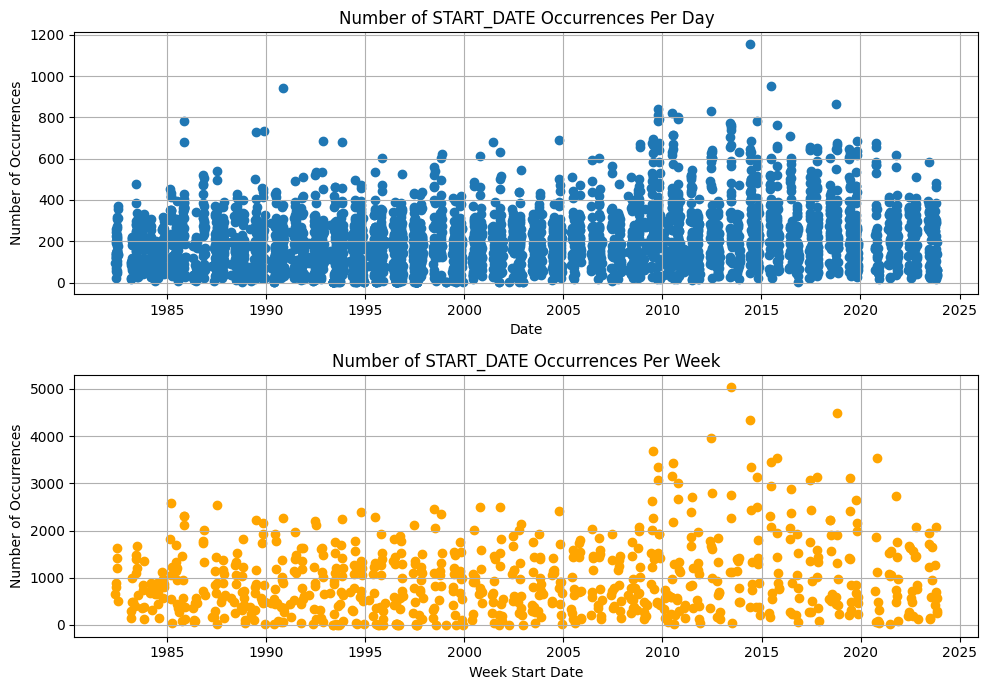

In [10]:
# Count occurrences within the same day/week
day_counts = df_filtered['DATE'].value_counts().sort_index()
week_counts = df_filtered['WEEK'].value_counts().sort_index()

# Calculate unique entries
unique_days = day_counts.shape[0]
unique_weeks = week_counts.shape[0]

# Display the number of unique day and week entries
print(f"Number of unique day entries: {unique_days}")
print(f"Number of unique week entries: {unique_weeks}")

# Plotting the results
plt.figure(figsize=(10, 7))

# Plot for daily counts
plt.subplot(2, 1, 1)
plt.scatter(day_counts.index, day_counts.values, marker='o')
plt.title('Number of START_DATE Occurrences Per Day')
plt.xlabel('Date')
plt.ylabel('Number of Occurrences')
plt.grid(True)

# Plot for weekly counts
plt.subplot(2, 1, 2)
plt.scatter(week_counts.index, week_counts.values, marker='o', color='orange')
plt.title('Number of START_DATE Occurrences Per Week')
plt.xlabel('Week Start Date')
plt.ylabel('Number of Occurrences')
plt.grid(True)

plt.tight_layout()
plt.show()


In [11]:
# We want to preserve info so choose days to group the species BIO_BGS counts by
df_filtered.drop(columns=['WEEK'], inplace=True)

# Check species count for unique day
We want to check how many unique species per day we have to see if species variety is relatively steady through time (i.e. check for sampling bias).

Unique BIO_BGS values per unique day:
DATE
1982-06-01    46
1982-06-02    49
1982-06-03    79
1982-06-04    56
1982-06-05    32
              ..
2023-11-10    31
2023-11-11    46
2023-11-12    35
2023-11-18    62
2023-11-19    87
Name: BIO_BGS, Length: 3403, dtype: int64


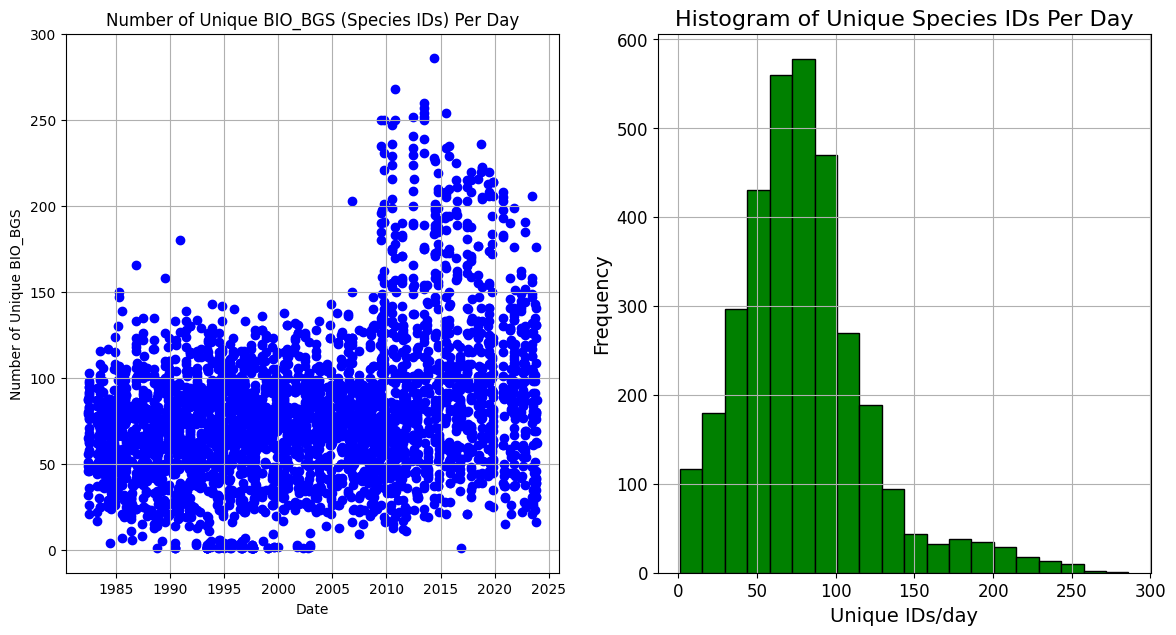

<Figure size 640x480 with 0 Axes>

In [12]:
# Group by DATE and count the number of unique BIO_BGS values per day
unique_bio_per_day = df_filtered.groupby('DATE')['BIO_BGS'].nunique().sort_index()

# Display the number of unique BIO_BGS entries per unique day
print("Unique BIO_BGS values per unique day:")
print(unique_bio_per_day)

# Plotting the number of unique BIO_BGS values per day
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.scatter(unique_bio_per_day.index, unique_bio_per_day.values, marker='o', linestyle='-', color='blue')
plt.title('Number of Unique BIO_BGS (Species IDs) Per Day')
plt.xlabel('Date')
plt.ylabel('Number of Unique BIO_BGS')
plt.grid(True)

# Plotting the histogram of unique BIO_BGS counts per day
plt.subplot(1, 2, 2)
plt.hist(unique_bio_per_day.values, bins=20, color='green', edgecolor='black')
plt.title('Histogram of Unique Species IDs Per Day', fontsize=16)
plt.xlabel('Unique IDs/day', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Increase the font size of the tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True)
plt.show()

plt.tight_layout()
plt.show()


# Average by daily amount and check STD for good fit

In [13]:
import pandas as pd
import numpy as np

# Assuming df_filtered is your filtered DataFrame and contains the columns 'DATE', 'BIO_BGS', 'CNT', and 'CNTEXP'

# Group by DATE and BIO_BGS, then sum CNTEXP for each group
grouped = df_filtered.groupby(['DATE', 'BIO_BGS'])['CNTEXP'].sum().reset_index()

# Group by DATE to calculate the number of unique BIO_BGS and the vector of CNTEXP for each DATE
daily_stats = grouped.groupby('DATE').agg(
    unique_bio_count=('BIO_BGS', 'nunique'),
    cntexp_vector=('CNTEXP', lambda x: list(x))
).reset_index()

# List of columns to exclude from averaging
columns_to_exclude = ['BIO_BGS', 'CNT', 'CNTEXP', 'DATE', 'DATE_DIFF', 'LAT_DIFF', 'LON_DIFF', 'SAMPLE_BGS']

# Identify columns to average and calculate std
columns_to_process = [col for col in df_filtered.columns if col not in columns_to_exclude]

# Group by DATE and calculate the mean and std for the columns of interest
averaged_columns = df_filtered.groupby('DATE')[columns_to_process].agg(['mean', 'std']).reset_index()

# Flatten the MultiIndex columns after aggregation
averaged_columns.columns = ['_'.join(col).strip() if col[1] else col[0] for col in averaged_columns.columns]

# Merge the calculated daily statistics and averaged columns back onto df_filtered
df_daily_species = daily_stats.merge(averaged_columns, on='DATE', how='left')

# Display the resulting DataFrame with the new columns
print(df_daily_species.head())

# df_final now contains:
# - DATE: The date of observations
# - unique_bio_count: The number of unique species (BIO_BGS) on that date
# - cntexp_vector: A list of CNTEXP values for each species on that date
# - [Other columns]: The mean and standard deviation of other columns for each date

         DATE  unique_bio_count  \
0  1982-06-01                46   
1  1982-06-02                49   
2  1982-06-03                79   
3  1982-06-04                56   
4  1982-06-05                32   

                                       cntexp_vector  PRECIP_mean  PRECIP_std  \
0  [1.0, 1.0, 31.0, 1522.0, 1.0, 10.0, 28.0, 3.0,...          NaN         NaN   
1  [7.0, 9.0, 12.0, 1.0, 15.0, 2.0, 10.0, 5.0, 1....          NaN         NaN   
2  [1.0, 1.0, 8.0, 7.0, 58.0, 2453.0, 3.0, 4.0, 2...          NaN         NaN   
3  [2.0, 10.0, 97.0, 14.0, 9.0, 1.0, 77.0, 9.0, 6...          NaN         NaN   
4  [1.0, 5.0, 15.0, 1.0, 9.0, 1.0, 22.0, 11.0, 10...          NaN         NaN   

   DEPTH_ESRF_mean  DEPTH_ESRF_std  DEPTH_EMID_mean  DEPTH_EMID_std  \
0              0.0             0.0         7.000000        0.000000   
1              0.0             0.0        17.521127        3.660051   
2              0.0             0.0        10.265625        4.741315   
3              0.0

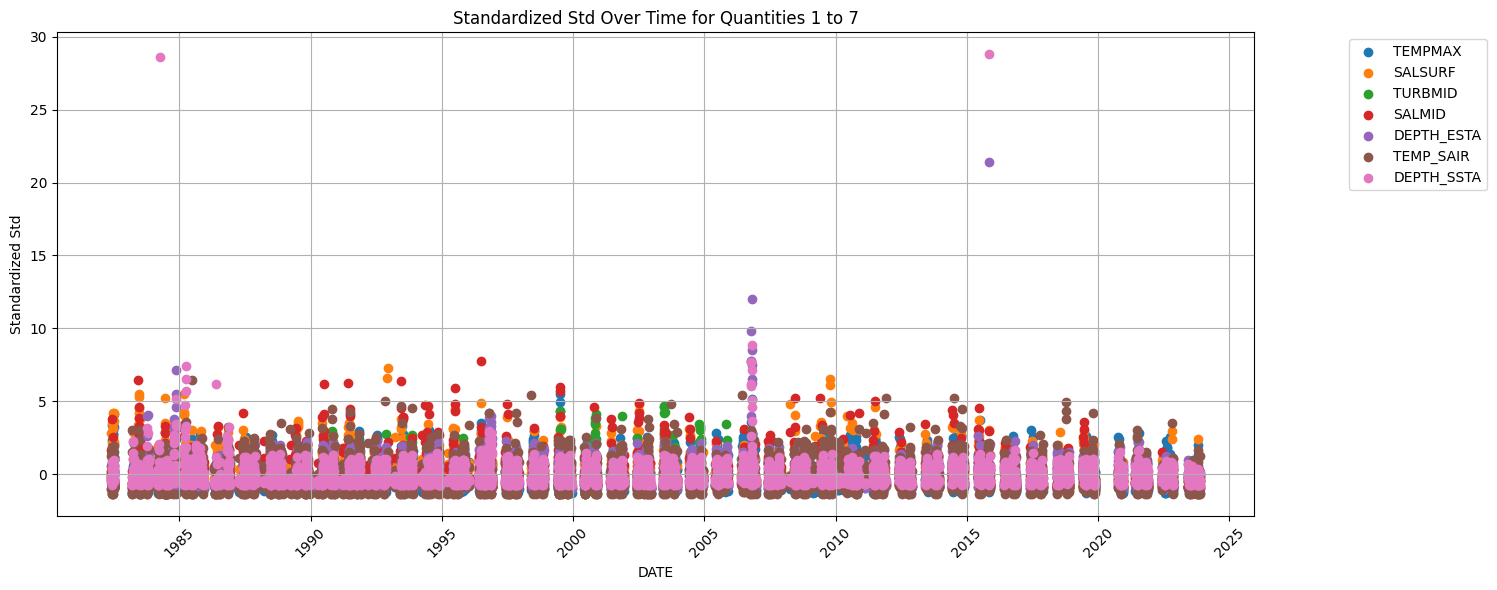

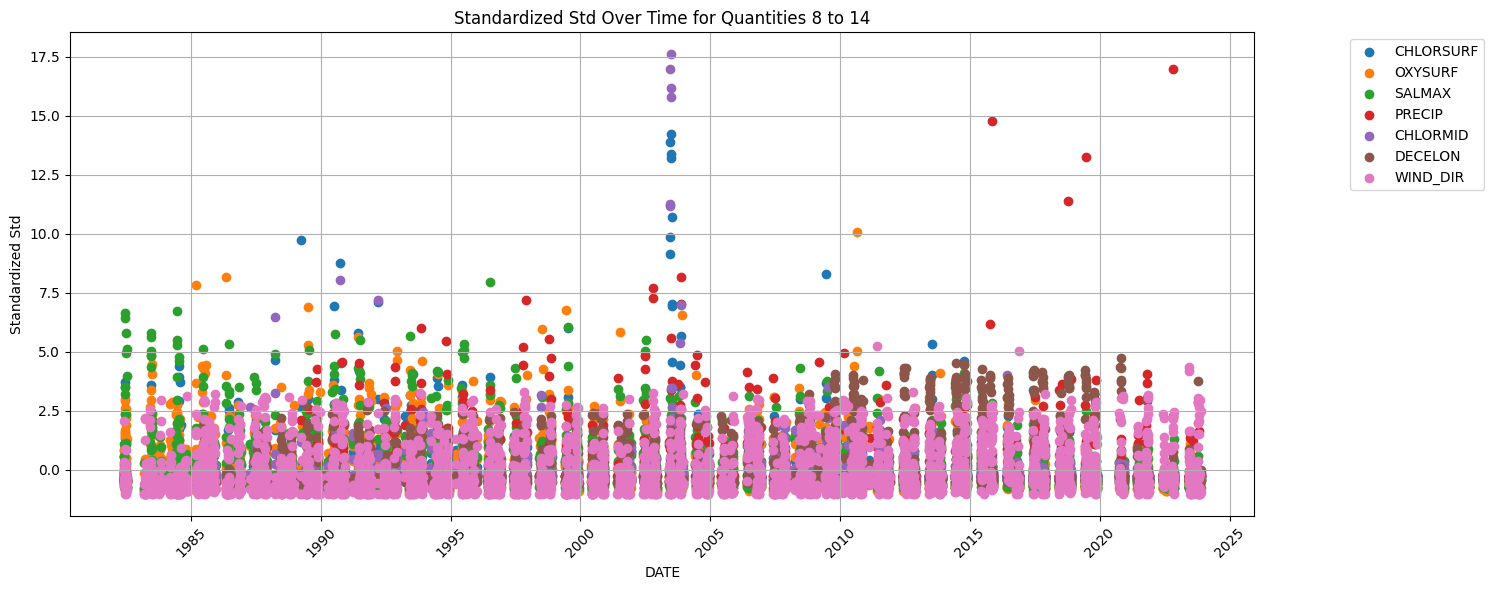

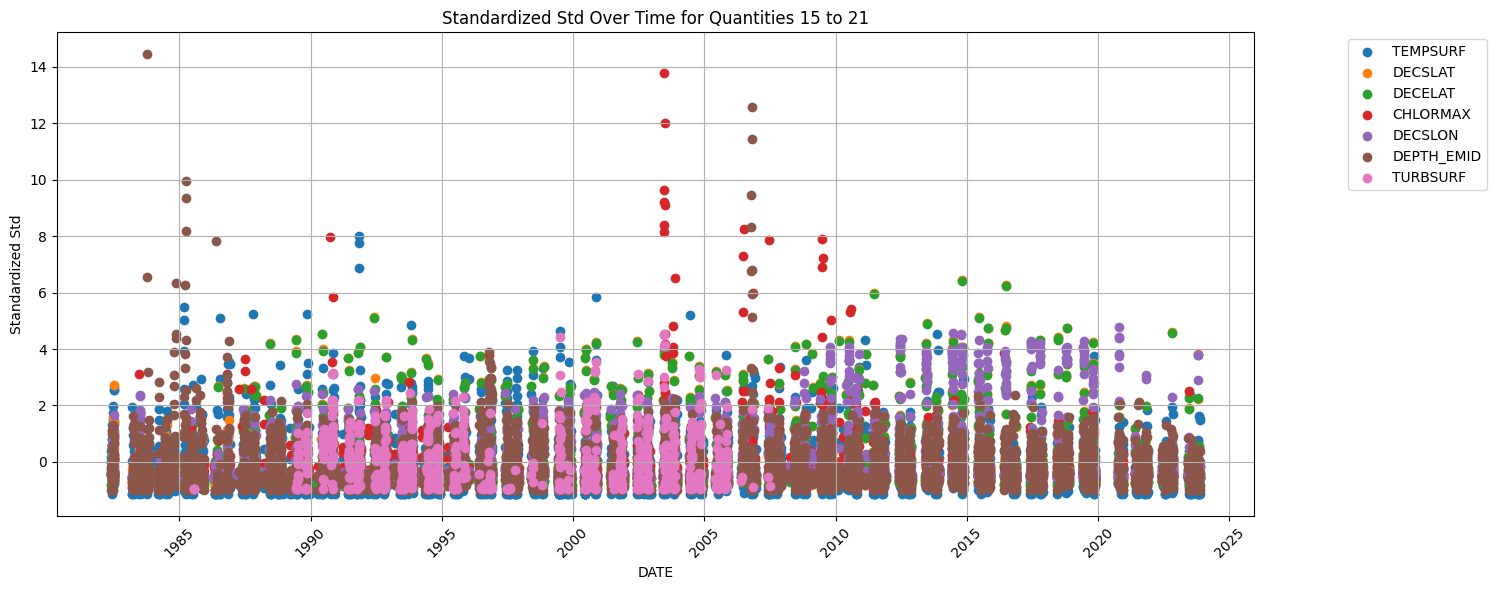

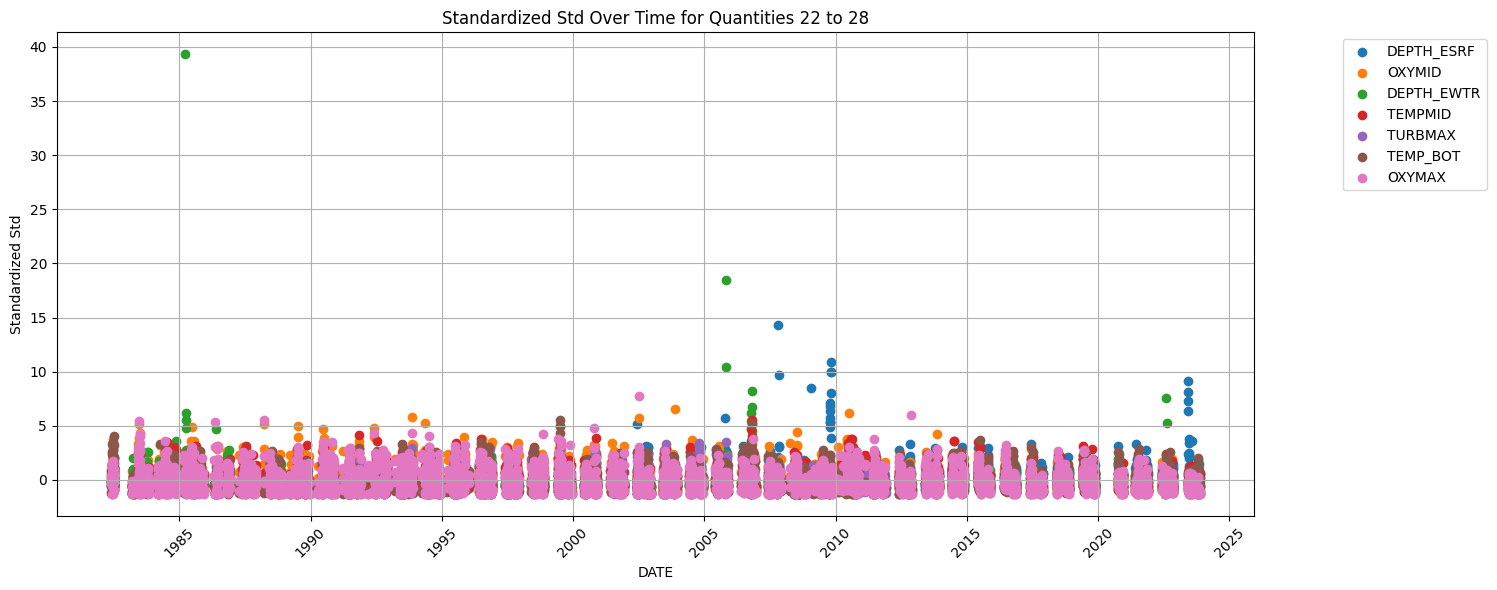

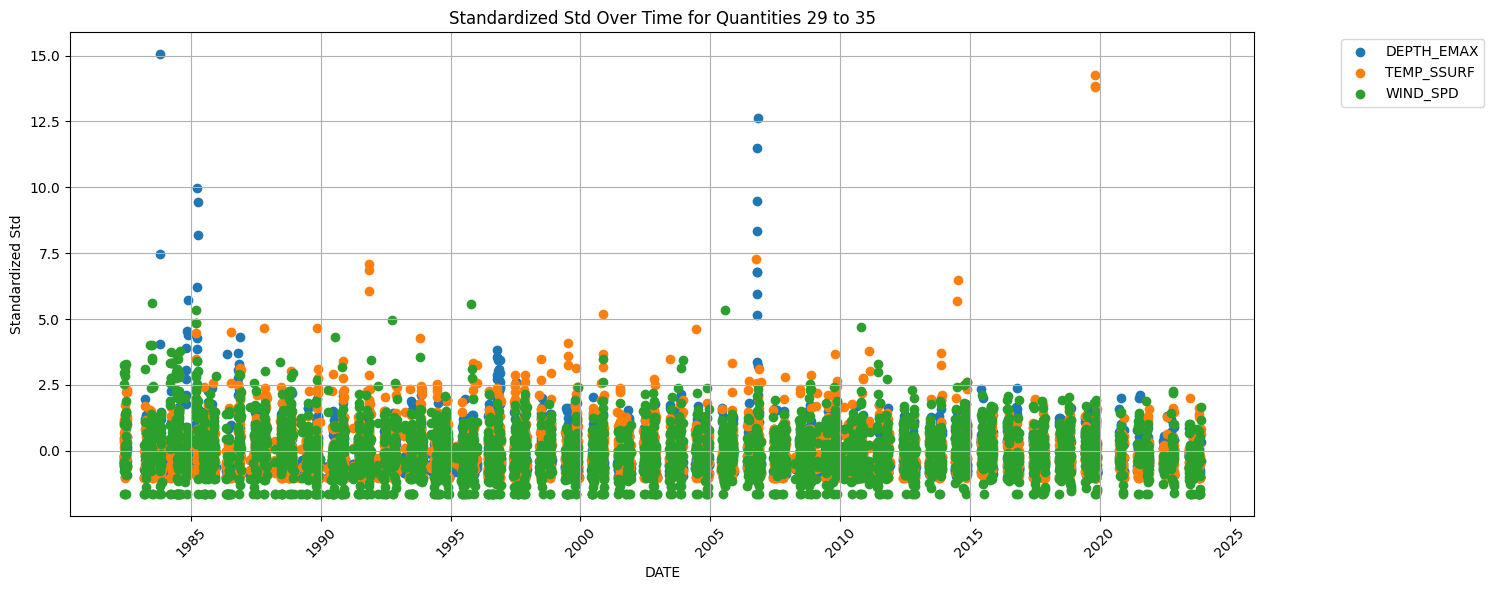

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming df_filtered is your DataFrame
# List of columns to exclude from analysis
columns_to_exclude = ['BIO_BGS', 'CNT', 'CNTEXP', 'DATE', 'SAMPLE_BGS',
                      'START_DATE_mean', 'START_DATE_std', 'END_DATE_mean', 'END_DATE_std']

# Identify columns to calculate the coefficient of variation (CV) for
std_columns = [col for col in df_daily_species.columns if 'std' in col and col not in columns_to_exclude]

# Initialize a DataFrame to store standardized std values
std_df = pd.DataFrame()

# Calculate the standardized std for each DATE and quantity
for std_col in std_columns:
    quantity_name = std_col.split('_std')[0]

    # Calculate the mean and std for the std column
    std_overall = df_daily_species[std_col].mean()
    std_std_overall = df_daily_species[std_col].std()

    # Standardize the std values
    standardized_std = (df_daily_species[std_col] - std_overall) / std_std_overall

    std_df[quantity_name] = standardized_std

# Add the DATE column back to the std_df
std_df['DATE'] = df_daily_species['DATE']

# Set DATE as the index for easier plotting
std_df.set_index('DATE', inplace=True)

# Calculate the average standardized std for each quantity
avg_std = std_df.mean()

# Sort quantities based on average standardized std in descending order
sorted_quantities = avg_std.sort_values(ascending=False).index

# Plotting in groups of 7
columns_per_plot = 7
for i in range(0, len(sorted_quantities), columns_per_plot):
    plt.figure(figsize=(15, 6))
    for col in sorted_quantities[i:i + columns_per_plot]:
        plt.scatter(std_df.index, std_df[col], label=col)

    plt.xlabel('DATE')
    plt.ylabel('Standardized Std')
    plt.title(f'Standardized Std Over Time for Quantities {i+1} to {i + columns_per_plot}')
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [15]:
df_daily_species.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3403 entries, 0 to 3402
Data columns (total 69 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   DATE              3403 non-null   object         
 1   unique_bio_count  3403 non-null   int64          
 2   cntexp_vector     3403 non-null   object         
 3   PRECIP_mean       2743 non-null   float64        
 4   PRECIP_std        2710 non-null   float64        
 5   DEPTH_ESRF_mean   3274 non-null   float64        
 6   DEPTH_ESRF_std    3243 non-null   float64        
 7   DEPTH_EMID_mean   3371 non-null   float64        
 8   DEPTH_EMID_std    3337 non-null   float64        
 9   DEPTH_EMAX_mean   3385 non-null   float64        
 10  DEPTH_EMAX_std    3351 non-null   float64        
 11  DEPTH_EWTR_mean   3399 non-null   float64        
 12  DEPTH_EWTR_std    3365 non-null   float64        
 13  DEPTH_SSTA_mean   3403 non-null   float64        
 14  DEPTH_SS

In [16]:
# Define a function to calculate Shannon entropy (H), Pielou's evenness index (J), and Simpson’s Diversity Index (D)
def calculate_health_metrics(row):
    cntexp_vector = row['cntexp_vector']
    S = row['unique_bio_count']

    if S > 1:
        N = sum(cntexp_vector)
        proportions = [cnt / N for cnt in cntexp_vector]

        # Shannon entropy (H)
        H = -sum([p * np.log(p) for p in proportions if p > 0])

        # Pielou's evenness index (J)
        J = H / np.log(S) if S > 1 else np.nan

        # Simpson’s Diversity Index (D)
        D = 1 - sum([p**2 for p in proportions])
    else:
        H = 0
        J = 0 if S == 1 else np.nan  # J is undefined if S=1, so it's set to 0
        D = 0 if S == 1 else np.nan  # D is undefined if S=1, so it's set to 0

    return pd.Series({'Shannon_entropy': H, 'Pielou_evenness': J, 'Simpson_diversity': D})

# Apply the function to df_daily_species to create the health metrics DataFrame
df_health_metrics = df_daily_species.apply(calculate_health_metrics, axis=1)

# Merge the health metrics with the original df_daily_species DataFrame
df_health_metrics = pd.concat([df_daily_species, df_health_metrics], axis=1)

# Display the resulting DataFrame with the health metrics
print(df_health_metrics.head())

# df_health_metrics now contains:
# - DATE: The date of observations
# - unique_bio_count: The number of unique species on that date
# - cntexp_vector: A list of CNTEXP values for each species on that date
# - Shannon_entropy: Shannon entropy (H) for each date
# - Pielou_evenness: Pielou's evenness index (J) for each date
# - Simpson_diversity: Simpson’s Diversity Index (D) for each date

         DATE  unique_bio_count  \
0  1982-06-01                46   
1  1982-06-02                49   
2  1982-06-03                79   
3  1982-06-04                56   
4  1982-06-05                32   

                                       cntexp_vector  PRECIP_mean  PRECIP_std  \
0  [1.0, 1.0, 31.0, 1522.0, 1.0, 10.0, 28.0, 3.0,...          NaN         NaN   
1  [7.0, 9.0, 12.0, 1.0, 15.0, 2.0, 10.0, 5.0, 1....          NaN         NaN   
2  [1.0, 1.0, 8.0, 7.0, 58.0, 2453.0, 3.0, 4.0, 2...          NaN         NaN   
3  [2.0, 10.0, 97.0, 14.0, 9.0, 1.0, 77.0, 9.0, 6...          NaN         NaN   
4  [1.0, 5.0, 15.0, 1.0, 9.0, 1.0, 22.0, 11.0, 10...          NaN         NaN   

   DEPTH_ESRF_mean  DEPTH_ESRF_std  DEPTH_EMID_mean  DEPTH_EMID_std  \
0              0.0             0.0         7.000000        0.000000   
1              0.0             0.0        17.521127        3.660051   
2              0.0             0.0        10.265625        4.741315   
3              0.0

In [17]:
# Define the function to calculate the cosine similarity balance metric
def calculate_balance_metric(cntexp_vector):
    n = len(cntexp_vector)

    if n == 0:
        return np.nan  # Handle cases where there are no species

    # Normalize the observed vector
    v = np.array(cntexp_vector) / np.linalg.norm(cntexp_vector)

    # Create the balanced vector (unit vector of ones)
    v_balanced = np.ones(n) / np.linalg.norm(np.ones(n))

    # Calculate the cosine similarity
    cos_theta = np.dot(v, v_balanced)

    return cos_theta

# Define the function to calculate the adjusted balance metric
def calculate_adjusted_balance_metric(row):
    cos_theta = row['balance_metric']
    S = row['unique_bio_count']  # Species richness

    # Calculate the adjusted metric by multiplying with log(S + 1)
    adjusted_metric = cos_theta * np.log(S + 1)

    return adjusted_metric

# Assuming df_daily_species is your DataFrame that contains 'unique_bio_count' and 'cntexp_vector'

# Apply the function to df_daily_species to create the balance metric
df_health_metrics['balance_metric'] = df_daily_species['cntexp_vector'].apply(calculate_balance_metric)

# Apply the function to create the adjusted balance metric
df_health_metrics['adjusted_balance_metric'] = df_health_metrics.apply(calculate_adjusted_balance_metric, axis=1)

# Display the resulting DataFrame with the new metrics
print(df_health_metrics[['balance_metric', 'adjusted_balance_metric']].head())

   balance_metric  adjusted_balance_metric
0        0.292900                 1.127709
1        0.373683                 1.461858
2        0.274903                 1.204633
3        0.210811                 0.852320
4        0.247815                 0.866486


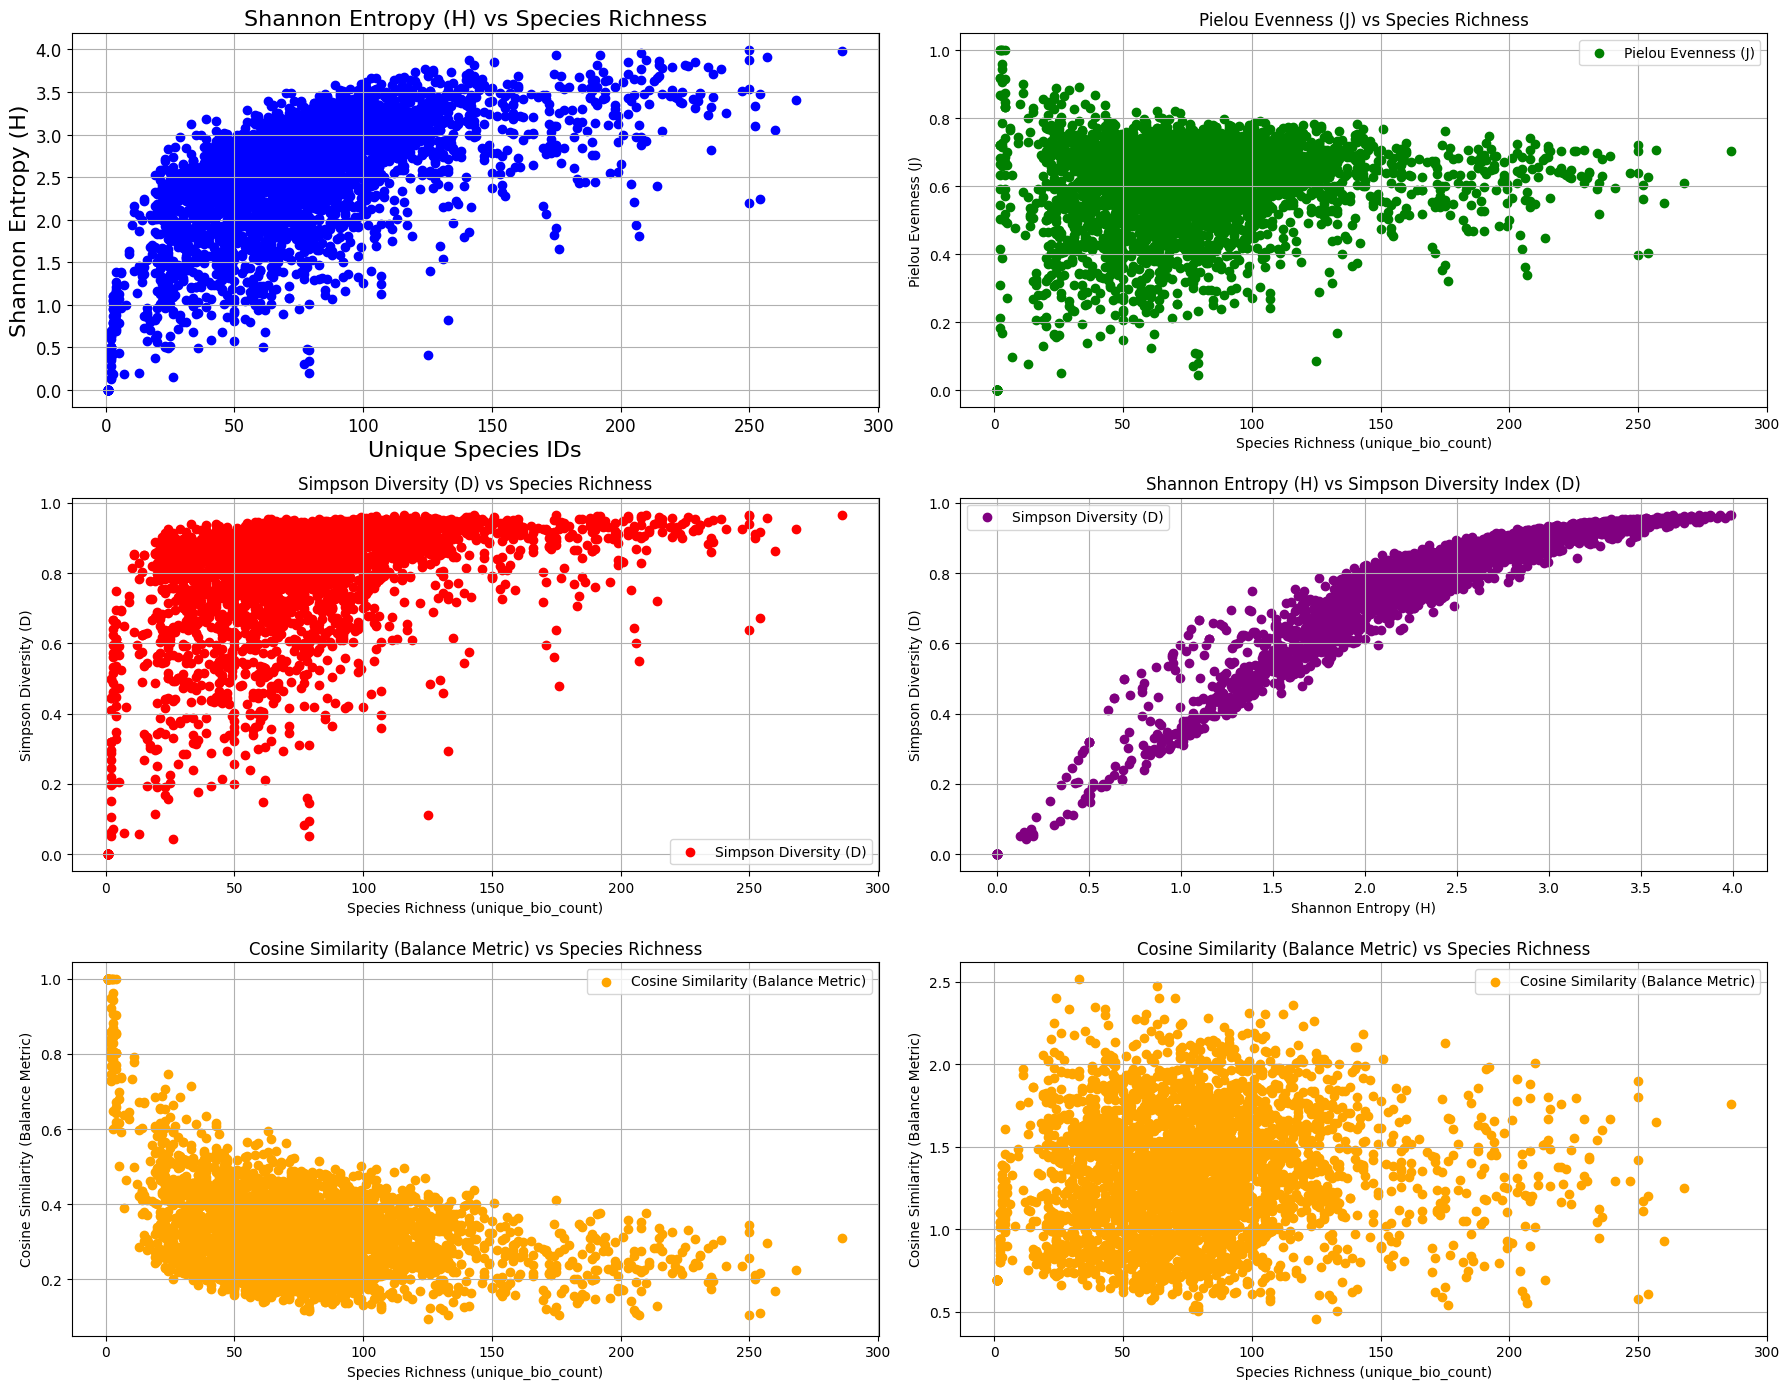

In [18]:

# Plotting the metrics
plt.figure(figsize=(18, 14))

# Plot Species Richness (unique_bio_count) vs Shannon Entropy (H)
plt.subplot(3, 2, 1)
plt.scatter(df_health_metrics['unique_bio_count'], df_health_metrics['Shannon_entropy'], c='blue', label='Shannon Entropy (H)')
plt.title('Shannon Entropy (H) vs Species Richness', fontsize=16)
plt.xlabel('Unique Species IDs', fontsize=16)
plt.ylabel('Shannon Entropy (H)', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)


# Plot Species Richness (unique_bio_count) vs Pielou's Evenness Index (J)
plt.subplot(3, 2, 2)
plt.scatter(df_health_metrics['unique_bio_count'], df_health_metrics['Pielou_evenness'], c='green', label='Pielou Evenness (J)')
plt.title('Pielou Evenness (J) vs Species Richness')
plt.xlabel('Species Richness (unique_bio_count)')
plt.ylabel('Pielou Evenness (J)')
plt.grid(True)
plt.legend()

# Plot Species Richness (unique_bio_count) vs Simpson's Diversity Index (D)
plt.subplot(3, 2, 3)
plt.scatter(df_health_metrics['unique_bio_count'], df_health_metrics['Simpson_diversity'], c='red', label='Simpson Diversity (D)')
plt.title('Simpson Diversity (D) vs Species Richness')
plt.xlabel('Species Richness (unique_bio_count)')
plt.ylabel('Simpson Diversity (D)')
plt.grid(True)
plt.legend()

# Plot Shannon Entropy (H) vs Simpson Diversity Index (D)
plt.subplot(3, 2, 4)
plt.scatter(df_health_metrics['Shannon_entropy'], df_health_metrics['Simpson_diversity'], c='purple', label='Simpson Diversity (D)')
plt.title('Shannon Entropy (H) vs Simpson Diversity Index (D)')
plt.xlabel('Shannon Entropy (H)')
plt.ylabel('Simpson Diversity (D)')
plt.grid(True)
plt.legend()

# Plot Species Richness (unique_bio_count) vs Cosine Similarity (Balance Metric)
plt.subplot(3, 2, 5)
plt.scatter(df_health_metrics['unique_bio_count'], df_health_metrics['balance_metric'], c='orange', label='Cosine Similarity (Balance Metric)')
plt.title('Cosine Similarity (Balance Metric) vs Species Richness')
plt.xlabel('Species Richness (unique_bio_count)')
plt.ylabel('Cosine Similarity (Balance Metric)')
plt.grid(True)
plt.legend()

# Plot Species Richness (unique_bio_count) vs Cosine Similarity (Balance Metric)
plt.subplot(3, 2, 6)
plt.scatter(df_health_metrics['unique_bio_count'], df_health_metrics['adjusted_balance_metric'], c='orange', label='Cosine Similarity (Balance Metric)')
plt.title('Cosine Similarity (Balance Metric) vs Species Richness')
plt.xlabel('Species Richness (unique_bio_count)')
plt.ylabel('Cosine Similarity (Balance Metric)')
plt.grid(True)
plt.legend()


plt.tight_layout()
plt.show()


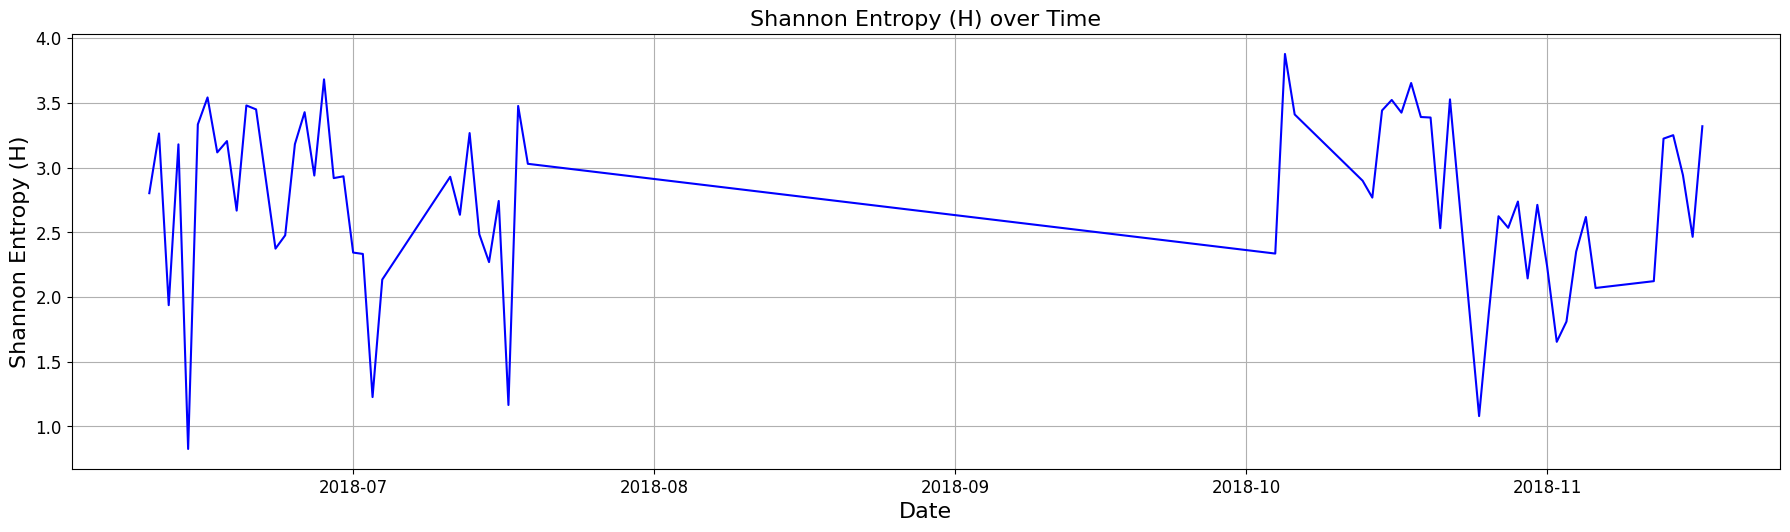

In [36]:
import matplotlib.pyplot as plt

# Ensure DATE is a datetime object if not already
df_health_metrics['DATE'] = pd.to_datetime(df_health_metrics['DATE'])

# Plotting the metrics over time in a stacked layout
plt.figure(figsize=(18, 25))

low_range = 3030
upper_range = 3095
# Plot Shannon Entropy (H) over time
plt.subplot(5, 1, 1)
plt.plot(df_health_metrics['DATE'][low_range:upper_range], df_health_metrics['Shannon_entropy'][low_range:upper_range], c='blue', label='Shannon Entropy (H)')
plt.title('Shannon Entropy (H) over Time', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Shannon Entropy (H)', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)


# plt.legend()

# # Plot Pielou's Evenness Index (J) over time
# plt.subplot(5, 1, 2)
# plt.plot(df_health_metrics['DATE'], df_health_metrics['Pielou_evenness'], c='green', label='Pielou Evenness (J)')
# plt.title('Pielou Evenness (J) over Time')
# plt.xlabel('Date')
# plt.ylabel('Pielou Evenness (J)')
# plt.grid(True)
# plt.legend()

# # Plot Simpson's Diversity Index (D) over time
# plt.subplot(5, 1, 3)
# plt.plot(df_health_metrics['DATE'], df_health_metrics['Simpson_diversity'], c='red', label='Simpson Diversity (D)')
# plt.title('Simpson Diversity (D) over Time')
# plt.xlabel('Date')
# plt.ylabel('Simpson Diversity (D)')
# plt.grid(True)
# plt.legend()

# # Plot Balance Metric (Cosine Similarity) over time
# plt.subplot(5, 1, 4)
# plt.plot(df_health_metrics['DATE'], df_health_metrics['balance_metric'], c='orange', label='Balance Metric (Cosine Similarity)')
# plt.title('Balance Metric (Cosine Similarity) over Time')
# plt.xlabel('Date')
# plt.ylabel('Balance Metric')
# plt.grid(True)
# plt.legend()

# # Plot Adjusted Balance Metric over time
# plt.subplot(5, 1, 5)
# plt.plot(df_health_metrics['DATE'], df_health_metrics['adjusted_balance_metric'], c='purple', label='Adjusted Balance Metric')
# plt.title('Adjusted Balance Metric over Time')
# plt.xlabel('Date')
# plt.ylabel('Adjusted Balance Metric')
# plt.grid(True)
# plt.legend()

plt.tight_layout()
plt.show()


# Output data to csv

In [20]:
# # Output df_health_metrics to a CSV file
# df_health_metrics.to_csv('BIODIV_health_metrics.csv', index=False)

# print("df_health_metrics has been saved to 'df_health_metrics.csv'.")